In [89]:
import os
import librosa
import math
import json
import matplotlib.pyplot as plt
import numpy as np
import json
from tqdm import tqdm
from IPython.display import clear_output
import os
import pickle
import tensorflow as tf
import logging as logger

logger.basicConfig(level=logging.INFO)

In [90]:
dataset_path = r"./Data/genres_original"
npz_path=r"./spects.npz"
SAMPLE_RATE = 22050
DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

## Preparation

- Extract Mel-Frequency Cepstral Coefficients (MFCCs) which are features of the audio files


In [91]:
pip install soundfile


Note: you may need to restart the kernel to use updated packages.


In [103]:

def save_chroma_tf_to_npz(dataset_path, npz_path, frame_length=2048, frame_step=512, num_segments=10, n_chroma=12):
    # Lists to store data
    chroma_features = []
    labels = []
    mapping = []

    # loop through all the genres
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath != dataset_path:
            # save the semantic label
            dirpath_comp = os.path.normpath(dirpath).split(os.sep)
            semantic_label = dirpath_comp[-1]
            mapping.append(semantic_label)

            # Create a tqdm progress bar for the filenames
            with tqdm(total=len(filenames), desc=f"Processing: {semantic_label}") as pbar:
                for f in filenames:
                    # Skip the problematic file
                    if f == "jazz.00054.wav":
                        continue

                    # Load audio file
                    file_path = os.path.join(dirpath, f)
                    audio_binary = tf.io.read_file(file_path)
                    waveform, sr = tf.audio.decode_wav(audio_binary)
                    waveform = tf.squeeze(waveform, axis=-1)
                    total_samples = int(SAMPLE_RATE * DURATION)

                    if waveform.shape[0] < total_samples:
                        logger.error(f"File {f} is too short for the given duration. Skipping or padding might be required.")
                        continue
                    samples_per_segment = int(SAMPLE_RATE * DURATION / num_segments)

                    for s in range(num_segments):
                        start_sample = samples_per_segment * s
                        end_sample = start_sample + samples_per_segment

                        # Generate STFT
                        stft = tf.signal.stft(
                            waveform[start_sample:end_sample],
                            frame_length=frame_length,
                            frame_step=frame_step
                        )
                        stft = tf.abs(stft)

                        # Convert STFT to chroma features using librosa
                        chroma = librosa.feature.chroma_stft(S=np.abs(stft.numpy().T), 
                                                             sr=SAMPLE_RATE, 
                                                             n_chroma=n_chroma)

                        # Append to data lists
                        chroma_features.append(chroma.tolist())
                        labels.append(i-1)
                        pbar.update(1)

    # Convert lists to numpy arrays
    chroma_features = np.array(chroma_features)
    labels = np.array(labels)
    mapping = np.array(mapping)

    # Save data as npz file
    np.savez_compressed(npz_path, chroma=chroma_features, labels=labels, mapping=mapping)
    logger.info(f"Data saved to {npz_path}")

# Use the function with your dataset path and desired npz file path
# save_chroma_tf_to_npz('path_to_dataset', 'path_to_save_data.npz')


In [104]:
file_path = r"./Data/genres_original/blues/blues.0000"

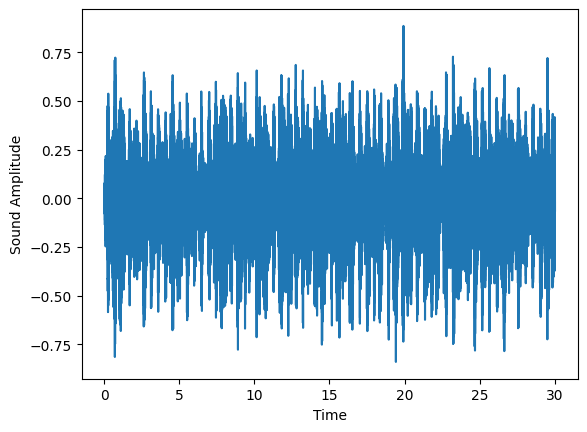

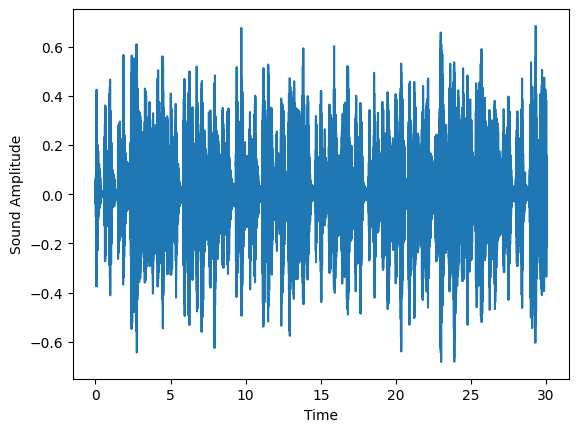

In [105]:
for i in range(2):
    audio, sfreq = librosa.load(file_path+str(i)+".wav")
    time = np.arange(0, len(audio))/sfreq
    plt.plot(time,audio)
    plt.xlabel("Time")
    plt.ylabel("Sound Amplitude")
    plt.show()

## Data Augmentation


In [106]:

def load_or_process_dataset(dataset_path, npz_path, *args, **kwargs):
    # Check if the cached data exists
    if os.path.exists(npz_path):
        # Load the cached data
        print(f"Loading cached data from {npz_path}")
        data = np.load(npz_path)
        inputs = data['chroma']
        targets = data['labels']
    else:
        # Process the dataset and save it as cached data
        print(f"Cached data not found, processing dataset from {dataset_path}")
        save_chroma_tf_to_npz(dataset_path, npz_path, *args, **kwargs)
        data = np.load(npz_path)
        inputs = data['chroma']
        targets = data['labels']

    return inputs, targets

In [107]:

inputs, targets = load_or_process_dataset(dataset_path, npz_path, frame_length=2048, frame_step=512, num_segments=5, n_chroma=12)
print("input shape:", inputs.shape)

Cached data not found, processing dataset from ./Data/genres_original


Processing: hiphop: 352it [00:07, 48.21it/s]                        ERROR:root:File hiphop.00032.wav is too short for the given duration. Skipping or padding might be required.
Processing: hiphop: 415it [00:08, 47.70it/s]ERROR:root:File hiphop.00031.wav is too short for the given duration. Skipping or padding might be required.
Processing: hiphop: 490it [00:10, 48.05it/s]
Processing: rock:  66%|██████▌   | 66/100 [00:01<00:00, 43.06it/s]ERROR:root:File rock.00038.wav is too short for the given duration. Skipping or padding might be required.
Processing: rock: 495it [00:11, 42.33it/s]                        
Processing: country: 114it [00:02, 42.40it/s]                        ERROR:root:File country.00003.wav is too short for the given duration. Skipping or padding might be required.
Processing: country: 342it [00:08, 41.74it/s]ERROR:root:File country.00007.wav is too short for the given duration. Skipping or padding might be required.
Processing: country: 447it [00:10, 41.28it/s]ERROR:

input shape: (4950, 12, 255)


In [108]:
## Split data into train and test sets
# splitting the data
from sklearn.model_selection import train_test_split

input_train, input_test, target_train, target_test = train_test_split(inputs, targets, test_size=0.3)
print(input_train.shape, target_train.shape)




(3465, 12, 255) (3465,)


In [109]:
# build the network architecture

from tensorflow.keras import Sequential
from tensorflow.keras.layers import *


In [110]:
model = Sequential()

model.add(Flatten(input_shape=(inputs.shape[1],inputs.shape[2])))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 3060)              0         
                                                                 
 dense_11 (Dense)            (None, 512)               1567232   
                                                                 
 dense_12 (Dense)            (None, 256)               131328    
                                                                 
 dense_13 (Dense)            (None, 64)                16448     
                                                                 
 dense_14 (Dense)            (None, 10)                650       
                                                                 
Total params: 1715658 (6.54 MB)
Trainable params: 1715658 (6.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [111]:
from tensorflow.keras import optimizers
adam = optimizers.Adam(learning_rate=1e-4)

In [112]:
from tensorflow.keras import optimizers
adam = optimizers.Adam(lr=1e-4)

In [113]:
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

In [114]:
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

hist = model.fit(input_train, target_train,
                 validation_data = (input_test,target_test),
                 epochs = 50,
                 batch_size = 32)
clear_output()

In [115]:
def plot_history(hist):
    plt.figure(figsize=(20,15))
    fig, axs = plt.subplots(2)
    # accuracy subplot
    axs[0].plot(hist.history["accuracy"], label="train accuracy")
    axs[0].plot(hist.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # Error subplot
    axs[1].plot(hist.history["loss"], label="train error")
    axs[1].plot(hist.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

<Figure size 2000x1500 with 0 Axes>

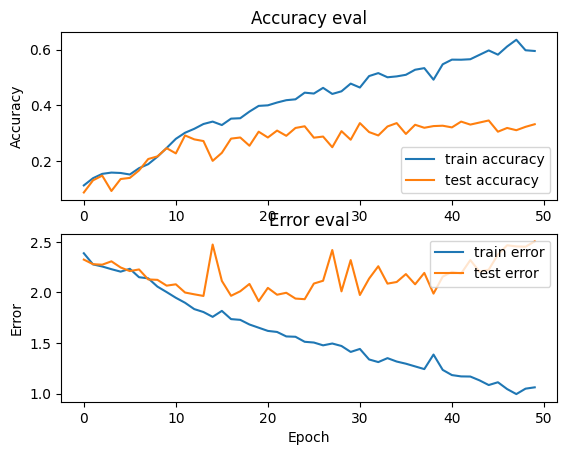

In [116]:
plot_history(hist)

In [117]:
test_error, test_accuracy = model.evaluate(input_test, target_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

47/47 [==============================] - 0s 2ms/step - loss: 2.5047 - accuracy: 0.3320
Test accuracy: 0.33198654651641846


## Overfitting

This part deals with the overfitting of the previous model. We can deal with it by majorly doing the following process.

Making architecture less complicated
Using augmented data
Early stopping of training
Adding dropout layers
Regularization / Standardization
I have added the dropout layers and kernel_regularizers as compared to previous naive model giving the dropout probability as 30% Kernel_regularizers is one of the 3 type of regularizer used to impose penalties. More info can be found


In [118]:
import tensorflow.keras as keras

In [119]:
# Overfitting

model = Sequential()

model.add(Flatten(input_shape=(inputs.shape[1],inputs.shape[2])))
model.add(Dense(512, activation='relu', kernel_regularizer = keras.regularizers.l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu', kernel_regularizer = keras.regularizers.l2(0.003)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer = keras.regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 3060)              0         
                                                                 
 dense_15 (Dense)            (None, 512)               1567232   
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_16 (Dense)            (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 64)                16448     
                                                                 
 dropout_6 (Dropout)         (None, 64)               

In [120]:
from keras.optimizers import Adam

adam = Adam(learning_rate=0.001)

model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

hist = model.fit(input_train, target_train,
                 validation_data = (input_test,target_test),
                 epochs = 50,
                 batch_size = 32)

clear_output()

<Figure size 2000x1500 with 0 Axes>

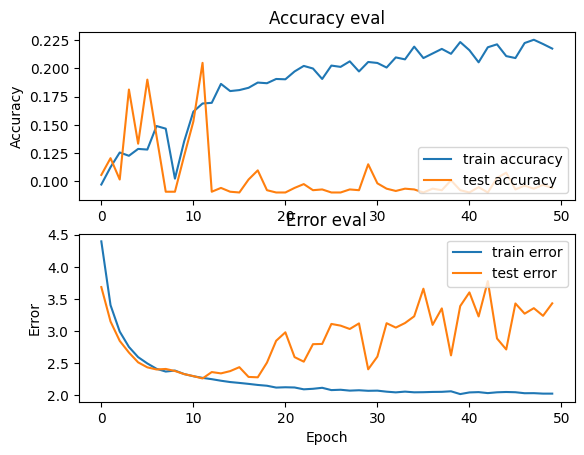

In [121]:
plot_history(hist)

In [122]:
test_error, test_accuracy = model.evaluate(input_test, target_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

47/47 [==============================] - 0s 2ms/step - loss: 3.4315 - accuracy: 0.0943
Test accuracy: 0.09427609294652939



CNN Using keras layers of Conv2D, MaxPool2D, BatchNormalization.

CNN layers takes input primarily in 3D shape, so we again have to prepare the dataset in the form and for that, I have used np.newaxis function which adds a column/layer in the data


In [123]:
from sklearn.model_selection import train_test_split

def prepare_dataset(npz_path, test_size, validation_size):
    # Load data from npz file
    with np.load(npz_path) as data:
        X = data['chroma']
        y = data['labels']

    # Split the dataset into training, validation, and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_size)

    # Expand the dimensions of X arrays to match the expected input of neural networks
    # If your model does not require a channel dimension, you can remove this step.
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_val, X_test, y_train, y_val, y_test



In [124]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(npz_path, test_size=0.25, validation_size=0.2)


In [125]:
input_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])
print(input_shape)

(12, 255, 1)


In [126]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation = "relu", input_shape = input_shape))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation = "relu"))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (2, 2), activation = "relu"))
model.add(MaxPool2D((2, 2), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(16, (1, 1), activation = "relu"))
model.add(MaxPool2D((1, 1), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation="softmax"))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 10, 253, 64)       640       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 5, 127, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization_4 (Bat  (None, 5, 127, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 125, 32)        18464     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 2, 63, 32)         0         
 g2D)                                                            
                                                      

In [127]:
from keras.optimizers import Adam

model.compile(optimizer=Adam(),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

hist = model.fit(X_train, y_train,
                 validation_data = (X_val, y_val),
                 epochs = 40,
                 batch_size = 32)

Epoch 1/40
93/93 [==============================] - 3s 19ms/step - loss: 2.3652 - accuracy: 0.2142 - val_loss: 2.3495 - val_accuracy: 0.0929
Epoch 2/40
93/93 [==============================] - 2s 16ms/step - loss: 1.8399 - accuracy: 0.3506 - val_loss: 2.8729 - val_accuracy: 0.0915
Epoch 3/40
93/93 [==============================] - 2s 17ms/step - loss: 1.6415 - accuracy: 0.4160 - val_loss: 3.6805 - val_accuracy: 0.0915
Epoch 4/40
93/93 [==============================] - 2s 18ms/step - loss: 1.5228 - accuracy: 0.4672 - val_loss: 2.7298 - val_accuracy: 0.2059
Epoch 5/40
93/93 [==============================] - 2s 18ms/step - loss: 1.3964 - accuracy: 0.4951 - val_loss: 2.6019 - val_accuracy: 0.2355
Epoch 6/40
93/93 [==============================] - 2s 19ms/step - loss: 1.3426 - accuracy: 0.5376 - val_loss: 2.4827 - val_accuracy: 0.2584
Epoch 7/40
93/93 [==============================] - 2s 19ms/step - loss: 1.2777 - accuracy: 0.5527 - val_loss: 1.8464 - val_accuracy: 0.3661
Epoch 8/40
93

<Figure size 2000x1500 with 0 Axes>

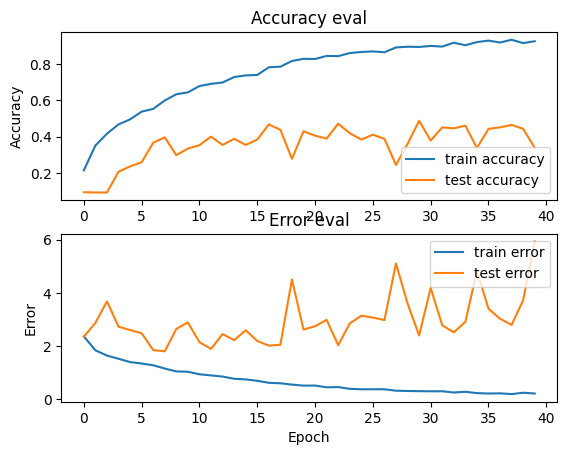

In [128]:
plot_history(hist)

In [129]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

39/39 [==============================] - 0s 6ms/step - loss: 6.0778 - accuracy: 0.3312
Test accuracy: 0.33117932081222534


In [130]:
def predict(model, X, y):
    X = X[np.newaxis,...]
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)
    print(f"Expected index: {y}, Predicted index: {predicted_index}")

In [131]:
predict(model, X_test[10], y_test[10])

1/1 [==============================] - 0s 68ms/step
Expected index: 8, Predicted index: [7]
